In [11]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Compute benchmark forecast from Obs as an extrapolated value for each DOY 
using data since 1990
Smooth the data with 7 day running mean first 
Then for a given DOY, use LOESS fit first then polynomial fit and extrapolate from
polynomial fit.
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from esio import EsioData as ed
from esio import ice_plot
from esio import import_data
from esio import metrics
import dask

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# from dask.distributed import Client
# client = Client(n_workers=2)
# client = Client()
# client
dask.config.set(scheduler='threads')  # overwrite default with threaded scheduler
# dask.config.set(scheduler='processes')  # overwrite default with threaded scheduler

In [13]:
# Parameters
pred_year = 2019 # Prediction year
start_year = 1990

In [14]:
#############################################################
# Load in Data
#############################################################

E = ed.EsioData.load()
mod_dir = E.model_dir

# Get bootstrap and nrt observations with pole hole already filled in
ds_81 = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'_yearly/*.nc', concat_dim='time', autoclose=True, parallel=True).sic
#ds_51 = xr.open_mfdataset(E.obs['NSIDC_0051']['sipn_nc']+'_yearly/*.nc', concat_dim='time', autoclose=True, parallel=True)
ds_79 = xr.open_mfdataset(E.obs['NSIDC_0079']['sipn_nc']+'_yearly/*.nc', concat_dim='time', autoclose=True, parallel=True).sic
ds_79=ds_79.sel(time=slice(str(start_year-1),str(pred_year-1)))  # starting in 1990 is good enough
ds_81=ds_81.sel(time=slice('2018',str(pred_year)))  # restrict to before prediciton year


In [15]:
ds_81.time[0].values, ds_81.time[-1].values

(numpy.datetime64('2018-01-01T00:00:00.000000000'),
 numpy.datetime64('2019-04-06T00:00:00.000000000'))

In [16]:
ds_79.time[0].values, ds_79.time[-1].values

(numpy.datetime64('1989-01-01T00:00:00.000000000'),
 numpy.datetime64('2017-12-31T00:00:00.000000000'))

In [17]:
# Combine bootstrap with NASA NRT
da_sic = ds_79.combine_first(ds_81)
#da_sic=ds_81  # for testing

In [18]:
ds_79 = None
ds_81 = None

In [19]:
# smooth the data with 7-day running mean
ocnmask = da_sic.isel(time=-30).notnull()  # take a value near the end when not likely to have missing values
ocnmask.name = 'oceanmask'
print(ocnmask)
tmpsic=da_sic.isel(time=30) # save one time at random for plot verification
#min_periods fixes problem of nans polluting answer
da_sic=da_sic.rolling(time=7,min_periods=1, center=True).mean().where(ocnmask)
da_sic.name = 'sic'
print(da_sic)
da_sic = da_sic.where(da_sic > 0, other=0).where(ocnmask)
da_sic = da_sic.where(da_sic < 1, other=1).where(ocnmask)

<xarray.DataArray 'oceanmask' (y: 448, x: 304)>
dask.array<shape=(448, 304), dtype=bool, chunksize=(448, 304)>
Coordinates:
    time     datetime64[ns] 2019-03-08
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
<xarray.DataArray 'sic' (time: 11052, y: 448, x: 304)>
dask.array<shape=(11052, 448, 304), dtype=float64, chunksize=(11052, 448, 304)>
Coordinates:
  * time     (time) datetime64[ns] 1989-01-01 1989-01-02 ... 2019-04-06
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 44

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


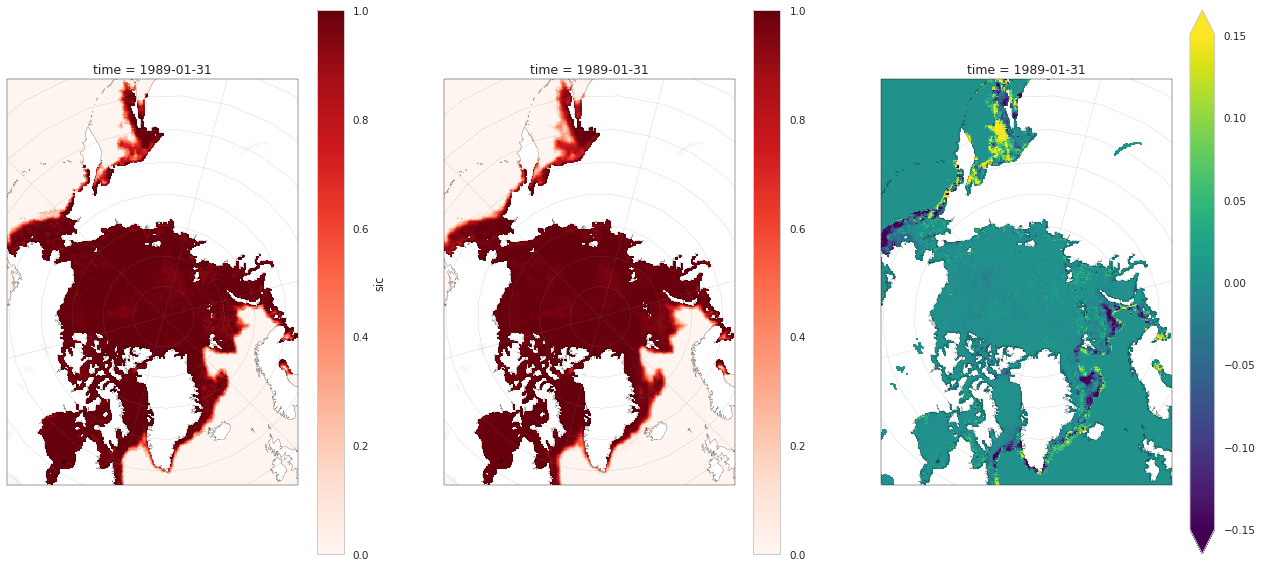

In [20]:
# plot one time at random to ensure it is about right
(f, axes) = ice_plot.multi_polar_axis(ncols=4, nrows=1,sizefcter=5)
tmpsic.plot.pcolormesh(cmap='Reds',ax=axes[0], x='lon', y='lat',transform=ccrs.PlateCarree())
da_sic.isel(time=30).plot.pcolormesh(cmap='Reds',ax=axes[1], x='lon', y='lat',transform=ccrs.PlateCarree())
tmp=da_sic.isel(time=30)-tmpsic
tmp.plot.pcolormesh(ax=axes[2], x='lon', y='lat',transform=ccrs.PlateCarree(),vmin=-.15, vmax=.15)
#ocnmask.plot.pcolormesh(ax=axes[2], x='lon', y='lat',transform=ccrs.PlateCarree())

In [21]:
da_sic=da_sic.sel(time=slice('1990',str(pred_year-1))) 

# Reshape as year x doy
# Add DOY
DOY_all = [x.timetuple().tm_yday for x in pd.to_datetime(da_sic.time.values)]
da_sic.coords['doy'] = xr.DataArray(DOY_all, dims='time', coords={'time':da_sic.time})
year_all = [x.year for x in pd.to_datetime(da_sic.time.values)]
da_sic.coords['year'] = xr.DataArray(year_all, dims='time', coords={'time':da_sic.time})

print(da_sic)

<xarray.DataArray (time: 10591, y: 448, x: 304)>
dask.array<shape=(10591, 448, 304), dtype=float64, chunksize=(10591, 448, 304)>
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2018-12-31
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    doy      (time) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
    year     (time) int64 1990 1990 1990 1990 1990 ... 2018 2018 2018 2018 2018


# Climatology forecast

In [22]:
test_plots = False

cmod = 'climatology'
runType = 'forecast'
Last_N_years = 'all' # Number of years prior to pred_year to train on. Use 'all' to use all available.

if Last_N_years=='all':
    Last_N_years = (pred_year-da_sic.year.min()).item()



In [23]:
# equal to code in mertics.py but here for testing
from scipy import stats
import statsmodels.api as sm
from scipy.interpolate import InterpolatedUnivariateSpline


def _mymess(x=None, y=None, pyear=None):

    y[np.isnan(y)] = 0
    # lowess will return our "smoothed" data with a y value for at every x-value
    lowess = sm.nonparametric.lowess(y, x, frac=.3)  # higher frac is smoother

    # unpack the lowess smoothed points to their values
    lowess_y = list(zip(*lowess))[1]
    #print(lowess_y) # a smooted version of y without extrema
    
    gl = np.polyfit(x, lowess_y, 2)
    hl = np.poly1d(gl)

    znew = hl(pyear)
    zfit = hl(x)
    
    return (znew, zfit)


In [24]:
# explore the new method
cdoy = 220

# Select current day of year
da_cdoy = da_sic.where(da_sic.doy==cdoy, drop=True).swap_dims({'time':'year'})

# this is the slow part
#ytrain=da_cdoy[:,200,150].values
#ytrain=da_cdoy[:,200,200].values
#ytrain=da_cdoy[:,200,100].values
ytrain=da_cdoy[:,225,130].values

print(ytrain)

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


[0.98057143 0.98642857 0.99185714 0.99       0.998      0.99985714
 0.99342857 1.         0.99585714 0.97928571 1.         0.99071429
 0.992      0.98657143 0.98442857 0.97685714 0.97385714 0.93742857
 0.963      0.982      0.985      0.93642857 0.97057143 0.99985714
 1.         0.96757143 0.97928571 1.         0.89885714]


29
0.9631052076002828
0.9732769788937725
0.0


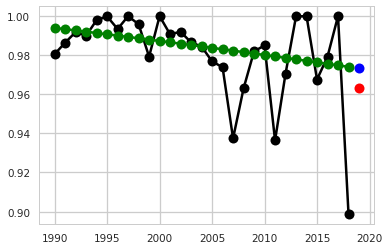

In [25]:
cyears=np.arange(1990,2019,1)
ypred=metrics._lrm(cyears, ytrain, pred_year)
ypred2, yfit =_mymess(cyears, ytrain, pred_year)
ypred3 = metrics._lowessext(cyears, np.nan*ytrain, pred_year)

print(len(yfit))
print(ypred)
f = plt.figure()
plt.plot(cyears,ytrain,marker='o',markersize=10,color='k')
plt.plot(2019,ypred,marker='o',markersize=10,color='r')

print(ypred2)
print(ypred3)
plt.plot(2019,ypred2,marker='o',markersize=10,color='b')
plt.plot(cyears,yfit,marker='o',markersize=10,color='g')

In [26]:
# Grab sic dataArray ?
#da_sic.load()

In [ ]:
for cdoy in np.arange(3,da_sic.doy.max().values+1,1):
    print("Processing day of year",cdoy)

    # Select current day of year
    da_cdoy = da_sic.where(da_sic.doy==cdoy, drop=True).swap_dims({'time':'year'})
    
    # Split by train and validate years (e.g. 1990 to 2018 for pred_year of 2019)
    da_train = da_cdoy.sel(year=slice(pred_year - Last_N_years, pred_year - 1)) #.where(ocnmask)
    print(da_train)
#    print(sum[np.isnan(da_train)])
    
    # Call model
#    ds_pred = metrics.linearRegressionModel(da_train.chunk({'year': -1}), 'year', pred_year) # Have to rechunk year into one big one
    ds_pred = metrics.LowessFitModel(da_train.chunk({'year': -1}), 'year', pred_year) # Have to rechunk year into one big one
    
    # Store
    ds_pred.coords['doy'] = cdoy
    
    # Force prediction SIC to be between 0-1
    ocnmask = ds_pred.notnull()
    ds_pred = ds_pred.where(ds_pred > 0, other=0).where(ocnmask)
    ds_pred = ds_pred.where(ds_pred < 1, other=1).where(ocnmask)
    
    if test_plots:
        xr.exit()
    
    # Move back to actual (valid_time) space
    ds_pred = ds_pred.expand_dims('time')
    ds_pred.coords['time'] = xr.DataArray([datetime.datetime(pred_year,1,1) + datetime.timedelta(days=int(x-1)) for x in [cdoy]], dims='time')
        
    ds_pred.name = 'sic'

    print(ds_pred)


    if not test_plots:
        # Save to disk
        file_out = os.path.join(mod_dir, cmod, runType, 'sipn_nc', str(pred_year)+'_'+format(cdoy, '03')+'_'+str(pred_year - Last_N_years)+'_'+str(pred_year - 1)+'_SIC.nc')
        ds_pred.to_netcdf(file_out)
        print("Saved",file_out)
    

Processing day of year 3
<xarray.DataArray (year: 29, y: 448, x: 304)>
dask.array<shape=(29, 448, 304), dtype=float64, chunksize=(29, 448, 304)>
Coordinates:
    time     (year) datetime64[ns] 1990-01-03 1991-01-03 ... 2018-01-03
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    doy      (year) int64 3 3 3 3 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * year     (year) int64 1990 1991 1992 1993 1994 ... 2014 2015 2016 2017 2018
<xarray.DataArray 'sic' (time: 1, y: 448, x: 304)>
dask.array<shape=(1, 448, 304), dtype=float64, chunksize=(1, 448, 304)>
Coordinates:
 

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Saved /home/disk/sipn/nicway/data/model/climatology/forecast/sipn_nc/2019_003_1990_2018_SIC.nc
Processing day of year 4
<xarray.DataArray (year: 29, y: 448, x: 304)>
dask.array<shape=(29, 448, 304), dtype=float64, chunksize=(29, 448, 304)>
Coordinates:
    time     (year) datetime64[ns] 1990-01-04 1991-01-04 ... 2018-01-04
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    doy      (year) int64 4 4 4 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4 4 4
  * year     (year) int64 1990 1991 1992 1993 1994 ... 2014 2015 2016 2017 2018
<xarray.DataArray 'sic' (time: 1, y: 448, 

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Saved /home/disk/sipn/nicway/data/model/climatology/forecast/sipn_nc/2019_004_1990_2018_SIC.nc
Processing day of year 5
<xarray.DataArray (year: 29, y: 448, x: 304)>
dask.array<shape=(29, 448, 304), dtype=float64, chunksize=(29, 448, 304)>
Coordinates:
    time     (year) datetime64[ns] 1990-01-05 1991-01-05 ... 2018-01-05
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    doy      (year) int64 5 5 5 5 5 5 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5 5 5 5 5 5
  * year     (year) int64 1990 1991 1992 1993 1994 ... 2014 2015 2016 2017 2018
<xarray.DataArray 'sic' (time: 1, y: 448, 

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Saved /home/disk/sipn/nicway/data/model/climatology/forecast/sipn_nc/2019_005_1990_2018_SIC.nc
Processing day of year 6
<xarray.DataArray (year: 29, y: 448, x: 304)>
dask.array<shape=(29, 448, 304), dtype=float64, chunksize=(29, 448, 304)>
Coordinates:
    time     (year) datetime64[ns] 1990-01-06 1991-01-06 ... 2018-01-06
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    doy      (year) int64 6 6 6 6 6 6 6 6 6 6 6 6 6 ... 6 6 6 6 6 6 6 6 6 6 6 6
  * year     (year) int64 1990 1991 1992 1993 1994 ... 2014 2015 2016 2017 2018
<xarray.DataArray 'sic' (time: 1, y: 448, 

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Saved /home/disk/sipn/nicway/data/model/climatology/forecast/sipn_nc/2019_006_1990_2018_SIC.nc
Processing day of year 7
<xarray.DataArray (year: 29, y: 448, x: 304)>
dask.array<shape=(29, 448, 304), dtype=float64, chunksize=(29, 448, 304)>
Coordinates:
    time     (year) datetime64[ns] 1990-01-07 1991-01-07 ... 2018-01-07
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    doy      (year) int64 7 7 7 7 7 7 7 7 7 7 7 7 7 ... 7 7 7 7 7 7 7 7 7 7 7 7
  * year     (year) int64 1990 1991 1992 1993 1994 ... 2014 2015 2016 2017 2018
<xarray.DataArray 'sic' (time: 1, y: 448, 

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Saved /home/disk/sipn/nicway/data/model/climatology/forecast/sipn_nc/2019_007_1990_2018_SIC.nc
Processing day of year 8
<xarray.DataArray (year: 29, y: 448, x: 304)>
dask.array<shape=(29, 448, 304), dtype=float64, chunksize=(29, 448, 304)>
Coordinates:
    time     (year) datetime64[ns] 1990-01-08 1991-01-08 ... 2018-01-08
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    doy      (year) int64 8 8 8 8 8 8 8 8 8 8 8 8 8 ... 8 8 8 8 8 8 8 8 8 8 8 8
  * year     (year) int64 1990 1991 1992 1993 1994 ... 2014 2015 2016 2017 2018
<xarray.DataArray 'sic' (time: 1, y: 448, 

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Saved /home/disk/sipn/nicway/data/model/climatology/forecast/sipn_nc/2019_008_1990_2018_SIC.nc
Processing day of year 9
<xarray.DataArray (year: 29, y: 448, x: 304)>
dask.array<shape=(29, 448, 304), dtype=float64, chunksize=(29, 448, 304)>
Coordinates:
    time     (year) datetime64[ns] 1990-01-09 1991-01-09 ... 2018-01-09
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    doy      (year) int64 9 9 9 9 9 9 9 9 9 9 9 9 9 ... 9 9 9 9 9 9 9 9 9 9 9 9
  * year     (year) int64 1990 1991 1992 1993 1994 ... 2014 2015 2016 2017 2018
<xarray.DataArray 'sic' (time: 1, y: 448, 

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Saved /home/disk/sipn/nicway/data/model/climatology/forecast/sipn_nc/2019_009_1990_2018_SIC.nc
Processing day of year 10
<xarray.DataArray (year: 29, y: 448, x: 304)>
dask.array<shape=(29, 448, 304), dtype=float64, chunksize=(29, 448, 304)>
Coordinates:
    time     (year) datetime64[ns] 1990-01-10 1991-01-10 ... 2018-01-10
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    doy      (year) int64 10 10 10 10 10 10 10 10 10 ... 10 10 10 10 10 10 10 10
  * year     (year) int64 1990 1991 1992 1993 1994 ... 2014 2015 2016 2017 2018
<xarray.DataArray 'sic' (time: 1, y: 448

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


# Clim trend last 10 years

### For presentation figures

In [ ]:
if test_plots:
    fig_dir = '/home/disk/sipn/nicway/Nic/figures/pres/A'

    cx = 160
    cy = 220

    sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
    f = plt.figure()
    da_train.isel(year=1).T.plot(label='Sea ice Concentration')
    plt.plot(cy,cx,marker='o',markersize=10,color='k')
    plt.title('')
    f_out = os.path.join(fig_dir,'spatial_plot.png')
    f.savefig(f_out,bbox_inches='tight', dpi=300)

    sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})





    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(da_train.isel(y=cy,x=cx).year.values, da_train.isel(y=cy,x=cx).values)
    predict_y = intercept + slope * da_train.isel(y=cy,x=cx).year.values
    predict_y

    f = plt.figure()
    da_train.isel(y=cy,x=cx).plot(color='b',label='Observed')
    plt.plot(2018, ds_pred.isel(y=cy,x=cx).values,'r*',label='Predicted',markersize=14)
    plt.plot(da_train.isel(y=cy,x=cx).year.values, predict_y,'k--', label='linear least-squares')
    plt.title('')
    plt.legend(loc='lower left', bbox_to_anchor=(1.03, .7))
    plt.ylabel('Sea Ice Concentration (-)')
    f_out = os.path.join(fig_dir,'linearfit.png')
    f.savefig(f_out,bbox_inches='tight', dpi=300)